In [22]:
%autosave 20
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy import optimize
import pandas as pd

Autosaving every 20 seconds


In [20]:
coord = SkyCoord(ra=5*u.hourangle, dec=-5*u.deg-23*u.arcmin,
                 radial_velocity=5*u.km/u.s,
                 distance=100*u.pc,
                 pm_ra_cosdec=1*u.mas/u.yr, pm_dec=-1*u.mas/u.yr)
display(coord.transform_to('galactic'))

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, pc)
    (204.61668338, -27.18344969, 100.)
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    (1.35101031, 0.41805639, 5.)>

<SkyCoord (CIRS: obstime=J2000.000): (ra, dec, distance) in (deg, deg, pc)
    (75.00537301, -5.38592396, 99.99999628)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-56064.66875155, -64131.82653705, 17.96993101)>

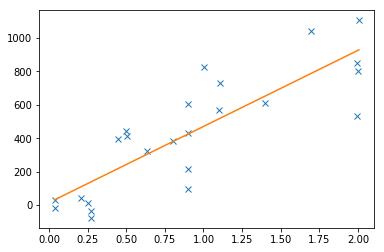

In [37]:
data = np.genfromtxt('diagram.csv', delimiter=',', names=('d', 'v'))
plt.plot(data['d'], data['v'], 'x')

def v_d(d, a, b):
    return a + b * d

def v_d_jac(d, a, b):
    jac = np.empty(d.shape + (2,))
    jac[:,0] = 1
    jac[:,1] = d
    return jac

(v0, H0), _ = optimize.curve_fit(v_d, data['d'], data['v'],
                                 (0, 500), jac=v_d_jac)

d_ = np.r_[data['d'].min():data['d'].max():100j]
plt.plot(d_, v_d(d_, v0, H0))

In [52]:
from astroquery import vizier
from astroquery import simbad
# conda install -c astropy astroquery
# pip3 install astroquery
m87 = simbad.Simbad.query_object('M87')
display(m87)
m87_coord = SkyCoord(ra=m87['RA'], dec=m87['DEC'],
                     unit=(u.hourangle, u.deg))
display(m87_coord)

viz = vizier.Vizier(
    column_filters={'Jmag': '<10'},
    row_limit=100,
)
tables = viz.query_region(m87_coord[0], radius=1*u.deg,
                          catalog='2MASS')
tables[0]

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object
M 87,12 30 49.4233,+12 23 28.043,9,9,0.250,0.017,90,A,R,2009A&A...493..317L


<SkyCoord (ICRS): (ra, dec) in deg
    [(187.70593042, 12.39112306)]>

RAJ2000,DEJ2000,_2MASS,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,Qflg,Rflg,Bflg,Cflg,Xflg,Aflg
deg,deg,,mag,mag,mag,mag,mag,mag,,,,,,
float64,float64,bytes17,float32,float32,float32,float32,float32,float32,bytes3,bytes3,bytes3,bytes3,uint8,uint8
187.384668,11.492561,12293232+1129332,7.734,0.024,7.550,0.027,7.525,0.024,AAA,111,111,000,0,0
187.034572,11.696364,12280829+1141469,9.324,0.027,8.952,0.022,8.906,0.023,AAA,222,111,000,0,0
187.452468,11.725997,12294859+1143335,8.399,0.026,8.027,0.040,7.951,0.017,AAA,111,111,000,0,0
187.479851,11.725157,12295516+1143305,9.802,0.023,9.301,0.023,9.205,0.021,AAA,222,111,000,0,0
187.630281,11.691707,12303126+1141301,9.451,0.036,9.064,0.044,8.868,0.027,EEE,222,111,c00,0,0
187.125600,11.767382,12283014+1146025,8.884,0.030,8.611,0.034,8.516,0.021,AAA,112,111,000,0,0
187.851927,11.755060,12312446+1145182,9.212,0.022,9.035,0.023,8.938,0.023,AAA,222,111,000,0,0
188.075788,11.790572,12321818+1147260,9.584,0.023,9.296,0.026,9.202,0.021,AAA,222,111,000,0,0


In [81]:
from scipy import integrate

# JLA
viz = vizier.Vizier(row_limit=1000)
tables = viz.get_catalogs('J/A+A/568/A22/tablef3')
t = tables[0]

def distance(z, Omega):
    """Luminosity distance, pc"""
    z = np.asarray(z, dtype=float)
    H0 = 70 / 1e6
    c = 3e5
    d = np.empty_like(z)
    for i, z_i in np.ndenumerate(z):
        d[i] = c / H0 * (1+z_i) * integrate.quad(
            lambda z: 1 / np.sqrt(Omega + (1-Omega) * (1+z)**3),
            0, z_i
        )[0]
    return d

def res(params, m, z, x1, c):
    Omega, M0, alpha, beta = params
    d = distance(z, Omega)
    m_th = M0 - 5 + 5*np.log10(d) - alpha * x1 + beta * c
    return m_th - m

result = optimize.least_squares(
    res,
    x0=(0.7, -19, 0.15, 2),
    args=(t['mb'], t['zcmb'], t['x1'], t['c']),
    bounds=([0, -22, 0, 0], [1, -18, 1, 3]),
)
print(result)
result.x

# import lmfit

 active_mask: array([0, 0, 0])
        cost: 10.570052101742341
         fun: <MaskedColumn name='x1' dtype='float64' length=740>
0.021282058144056037
-0.17635845722222498
 -0.0182790885464037
-0.14872565447865682
-0.27182356955313125
 0.27798067612144806
 0.06314672613605055
 0.13666835411755685
-0.12107218644429807
 -0.1098988633869844
-0.08689218861948333
 0.12286884771465267
                 ...
-0.16798386349589478
0.008762473695025363
-0.16625423469364264
 0.12894200899473063
0.019600891127151243
 0.08367782935281198
0.007105040712996669
 0.11298463625138666
   0.194534279932693
-0.12394845300535806
 0.01920676416535727
-0.06461656038566232
        grad: <MaskedColumn name='x1' dtype='float64' length=3>
-0.006843629535302376
  0.03138103254929803
  -0.2826112195655166
         jac: array([[ 0.77539682,  1.        , -1.        ],
       [ 0.87925053,  1.        , -1.        ],
       [ 0.76443148,  1.        ,  1.        ],
       ...,
       [ 0.03911877,  1.        , -0.5       

array([  0.72298385, -19.08708444,   0.11650636])

In [ ]:
?optimize.least_squares